# CSE4224 Project 2
#### Grant Butler | gbutler2020@my.fit.edu

#### Data Retrieval/Cleaning:
Here, I will use the Spotify API to get the audio features of the tracks in my library, and create a cleaned pandas dataframe to be used with PCA and t-SNE after.

In [6]:
# connect to spotify api

from dotenv import dotenv_values
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

# use dotenv to import api creds
secrets = dotenv_values(".env")

# making authentication manager for spotipy to communicate with spotify
# auth_manager = SpotifyClientCredentials(client_id=secrets["SPOTIPY_CLIENT_ID"],
#                                         client_secret=secrets["SPOTIPY_CLIENT_SECRET"])

auth_manager = SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'],
                                                 client_secret=secrets['SPOTIPY_CLIENT_SECRET'],
                                                 redirect_uri='http://127.0.0.1',
                                                 scope='user-library-read')

sp = spotipy.Spotify(auth_manager=auth_manager)  # making spotipy object
sp.trace = False  # no debugging needed

In [8]:
# getting track ids from playlist

# grabbing the track ids and adding them to an array passed into them
def show_tracks(results, uriArray):
    for i, item in enumerate(results['items']):
        track = item['track']
        uriArray.append(track['id'])

# taking in the tracks from the playlist and grabbing the ids before returning them to a list
def get_playlist_track_ids(username, playlist_id):
    track_ids = []  # to store track ids
    # playlist = sp.user_playlist(username, playlist_id)  # get playlist
    playlist = sp.current_user_saved_tracks()
    tracks = playlist  # getting tracks from playlist

    # loop through the tracks and append them with helper function
    while tracks['next']:
        tracks = sp.next(tracks)
        show_tracks(tracks, track_ids)
    return track_ids


track_ids = get_playlist_track_ids(secrets['SPOTIFY_USERNAME'],
                                   secrets['PLAYLIST_ID'])

print(track_ids)

['1NQCXMieTUMqVljCO8VCmR', '09MduMD14OZjmAxd6u1Qfi', '1LgfBZnwX0IDLNrVbMZbzV', '5glTcywxEIlhM8hArwp1IG', '5pcjKCZqBGv8kB3ToAjOnG', '3zYRfg6QfdBYuvTCeQyjVK', '3KFFPMe1nsk6BVz7MRQaFf', '0gqObamjYGPDrDashLtGzn', '6XInw1uowvKHrJZaiFd8sY', '6lor0TrU7UtjUerVWQkeoI', '2xP4yB74RKTBaC03qmQjtm', '4ag0tavOOhRpVhKQIWXbJN', '6Pt5ky10RuJCMwAQi8xJFy', '2Kduv9AAnVgA7mgkBtrr1R', '6FCfj69zzQHnrx4fTukhfo', '1GnqFzDEhriNWPv92ztVG0', '2uTvkHhMvrwZZmEDWfxCmn', '34opCYNMYR1wMwvCCItqsz', '1rejpodYM1kK2PjJ0t47qv', '2q5E2qgXkrLg1KPiWXYoWl', '5gc1YUM7XMyvzjJtNLXprG', '0GTK6TesV108Jj5D3MHsYb', '4xQUT86GMaywVur7QL3W9h', '2nDlxwB7G8xN2UXHEIRJOZ', '3SuxtjdFxY3RIaWyPgtkfk', '7hTdAaszcY2o1YpdQuWCV0', '1GTC0DN9LGOdP0NdvoHyX7', '5NAOhPAZ57eFAXr3qatS6i', '2B3ytFCShO5lhqUG7oELuR', '2HTzzn4hP4PHlX2nLotWF4', '07gf6qIWA6yt58pR7uBDSw', '4Z4i631BesV0P6LTvfLAdL', '4rvnBqTmx66LlCJZLbLAOY', '2gzIb9rrsQKz1AGBE2WmKF', '4ZVTe0Pn5sjcFu71Oel0i0', '4S7szZbzPP1Wt6bwtEfbpt', '54VI57hfP3r4WPz2jxrBDJ', '34r1FwoFv9a0LjQ1P9ZV2P', '2t3EhOmUxC

In [9]:
import json

# helper function to split up the bigger list of track ids (spotify api limits to 100 tracks)
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# taking in a chunk at a time, ensuring they are strings, and then adding on the features and returning them
def get_audio_features(track_ids):
    audio_features = []
    for chunk in chunks(track_ids, 100):
        chunk = [str(track_id) for track_id in chunk]
        audio_features.extend(sp.audio_features(chunk))
    return audio_features

audio_features = get_audio_features(track_ids)
print(json.dumps(audio_features, indent=2))

[
  {
    "danceability": 0.644,
    "energy": 0.875,
    "key": 8,
    "loudness": -5.709,
    "mode": 1,
    "speechiness": 0.199,
    "acousticness": 0.339,
    "instrumentalness": 4.11e-06,
    "liveness": 0.331,
    "valence": 0.578,
    "tempo": 104.022,
    "type": "audio_features",
    "id": "1NQCXMieTUMqVljCO8VCmR",
    "uri": "spotify:track:1NQCXMieTUMqVljCO8VCmR",
    "track_href": "https://api.spotify.com/v1/tracks/1NQCXMieTUMqVljCO8VCmR",
    "analysis_url": "https://api.spotify.com/v1/audio-analysis/1NQCXMieTUMqVljCO8VCmR",
    "duration_ms": 167540,
    "time_signature": 4
  },
  {
    "danceability": 0.67,
    "energy": 0.786,
    "key": 4,
    "loudness": -5.07,
    "mode": 0,
    "speechiness": 0.107,
    "acousticness": 0.039,
    "instrumentalness": 0,
    "liveness": 0.433,
    "valence": 0.578,
    "tempo": 106.009,
    "type": "audio_features",
    "id": "09MduMD14OZjmAxd6u1Qfi",
    "uri": "spotify:track:09MduMD14OZjmAxd6u1Qfi",
    "track_href": "https://api.sp

In [10]:
import pandas as pd

# ensuring there are no entries without data
cleaned_features = [item for item in audio_features if item is not None]

# making dataframe from the list of dicts
df = pd.DataFrame(cleaned_features)

# remove fields that have no bearing on analysis
fields_to_remove = ["analysis_url", "track_href", "type", "uri"]
df = df.drop(columns=fields_to_remove)

print(df)

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.644   0.875    8    -5.709     1       0.1990       0.33900   
1            0.670   0.786    4    -5.070     0       0.1070       0.03900   
2            0.907   0.660    0    -5.699     1       0.2610       0.03220   
3            0.715   0.771    1    -5.815     0       0.0678       0.29300   
4            0.543   0.204    7   -17.365     1       0.0441       0.92800   
...            ...     ...  ...       ...   ...          ...           ...   
2707         0.714   0.654    5    -6.868     0       0.3160       0.38500   
2708         0.826   0.553    5    -9.303     1       0.3160       0.43200   
2709         0.839   0.741    7    -7.270     1       0.0379       0.02940   
2710         0.559   0.640   11    -7.022     0       0.1240       0.16000   
2711         0.488   0.830    7    -5.331     1       0.0436       0.00127   

      instrumentalness  liveness  valence    tempo             

#### PCA Dimensional Reduction:

Using PCA, I hope to reduce the number of dimensions that t-SNE needs to work with.

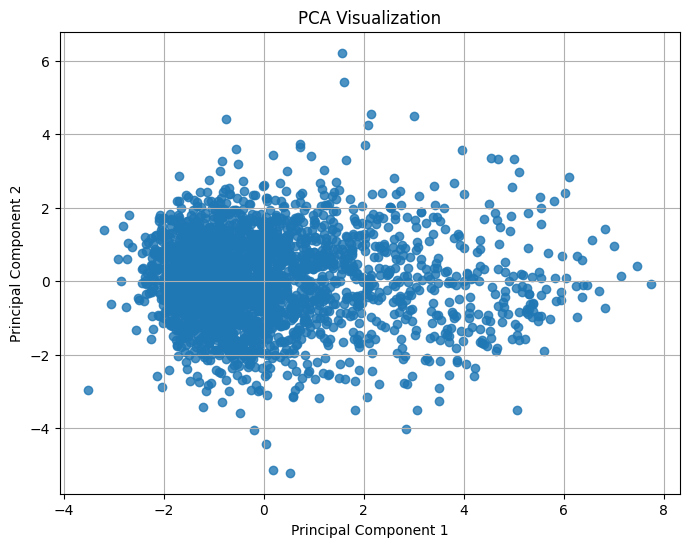

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# remove ids for numeric data only
df_numeric = df.drop(columns='id')

# use standard scaler to centeralize and normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# apply PCA
pca = PCA(n_components=3) # only 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# visualize PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualize PCA in 3D
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.8)
# ax.set_title('PCA Visualization in 3D')
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.grid(True)
# plt.show()

In [18]:
# checking loadings of principal components
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=df_numeric.columns)

print(loadings_df)

   danceability    energy       key  loudness      mode  speechiness  \
0     -0.300229 -0.454398 -0.009232 -0.489624  0.048759    -0.145057   
1      0.477892 -0.255622  0.054064 -0.151431  0.034605     0.409375   
2     -0.072168 -0.011624  0.663653  0.017257 -0.688051     0.051911   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.378731          0.358491 -0.107942 -0.289841 -0.158142    -0.118325   
1      0.248382         -0.187393 -0.116551  0.405932 -0.114670    -0.463850   
2      0.086970         -0.103185  0.146368 -0.047969 -0.141968     0.063863   

   time_signature  
0       -0.183105  
1       -0.090317  
2       -0.107917  


Principal Component 1: Explained Variance Ratio = 0.2364
Principal Component 2: Explained Variance Ratio = 0.1069
Principal Component 3: Explained Variance Ratio = 0.0928


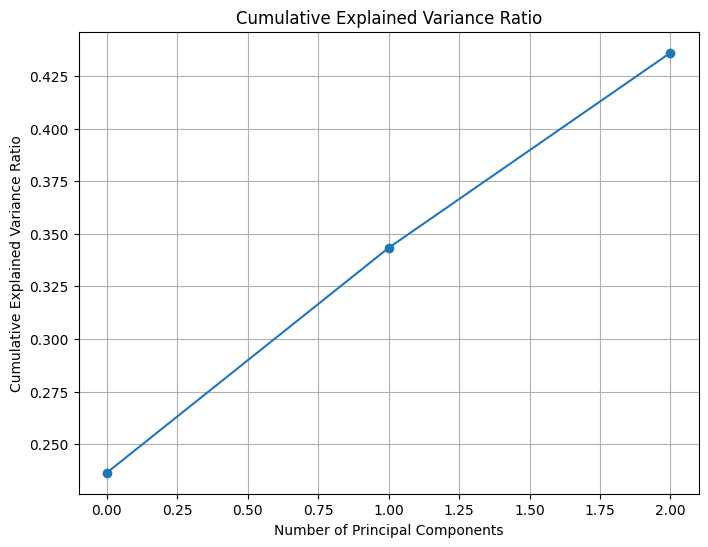

In [19]:
import numpy as np

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i + 1}: Explained Variance Ratio = {ratio:.4f}")

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [20]:


# sort the loadings to be the most impactful first

loadings_diff = np.abs(np.diff(loadings, axis=0))
loadings_diff_sum = loadings_diff.sum(axis=0)
loadings_diff_df = pd.DataFrame(
    loadings_diff_sum, index=df_numeric.columns, columns=['Sum of Loadings Diff'])

loadings_diff_sorted = loadings_diff_df.sort_values(by='Sum of Loadings Diff', ascending=False)

print(loadings_diff_sorted)

                  Sum of Loadings Diff
danceability                  1.328180
valence                       1.149674
speechiness                   0.911897
duration_ms                   0.873237
mode                          0.736809
key                           0.672885
instrumentalness              0.630091
loudness                      0.506881
energy                        0.442774
acousticness                  0.291761
liveness                      0.271528
time_signature                0.110387
tempo                         0.070772


#### Apply t-SNE on PCA Data

Using *t*-SNE on data from PCA.

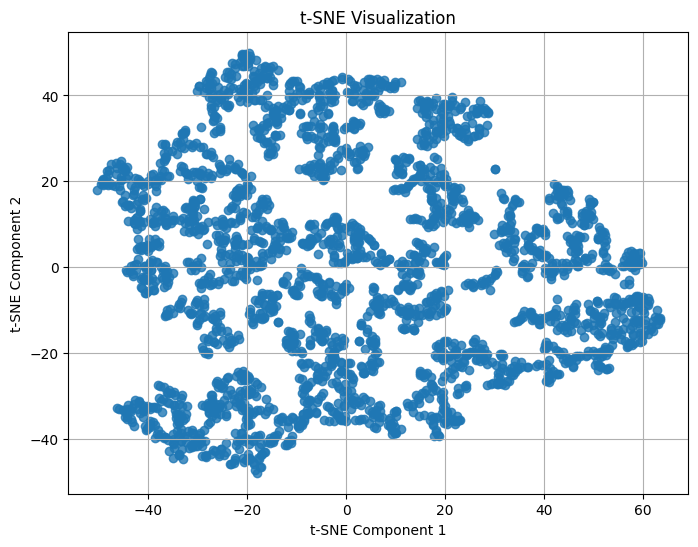

In [21]:
from sklearn.manifold import TSNE

# using 2 components for t-SNE for visualization after reducing with PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.8)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

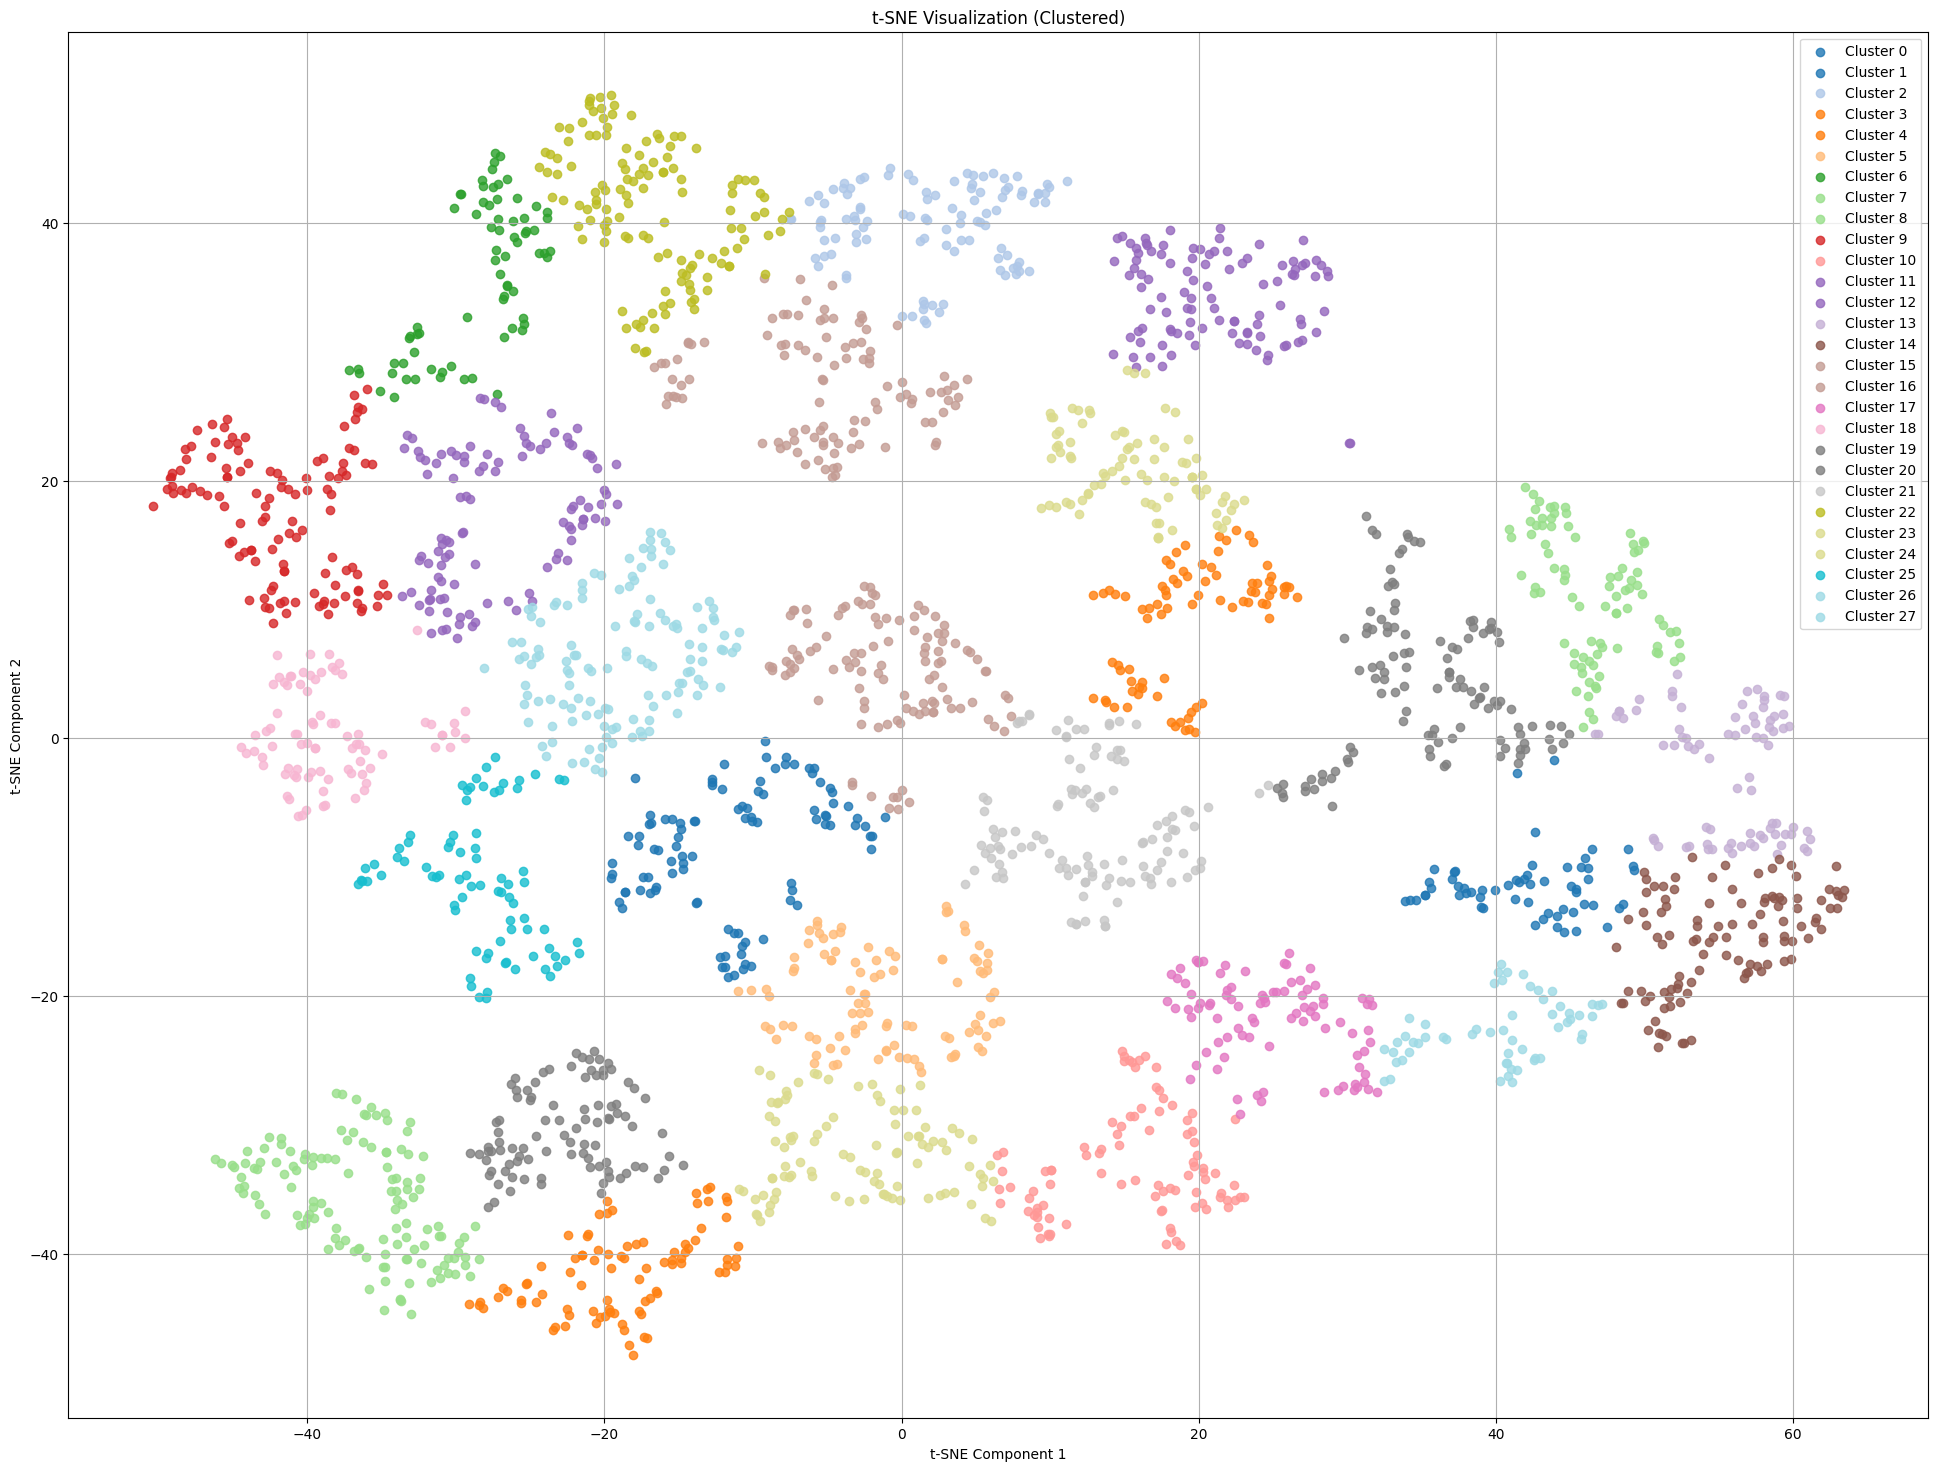

In [27]:
# using k-means to group the clusters and color them based on that

from sklearn.cluster import KMeans

num_clusters = 28

# apply k-means to t-SNE results
kmeans = KMeans(n_clusters=num_clusters, random_state=523)
clusters = kmeans.fit_predict(X_tsne)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(clusters))))

plt.figure(figsize=(24, 18))
for cluster_id, color in zip(np.unique(clusters), colors):
    cluster_indices = np.where(clusters == cluster_id)[0]
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices,
                1], label=f'Cluster {cluster_id}', color=color, alpha=0.8)
plt.title('t-SNE Visualization (Clustered)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend() # legends for whether you see which cluster is which
plt.grid(True)
plt.show()

In [23]:
# exporting the track ids with cluster information 
cluster_track_ids = {}
clusters = clusters.astype(int)
cluster_track_ids = [{'track_id': track_id, 'cluster_label': int(cluster_label)}
                     for track_id, cluster_label in zip(track_ids, clusters)]

sorted_tracks = sorted(cluster_track_ids, key=lambda x: x['cluster_label'])

with open('clustered_track_ids.json', 'w') as f:
    json.dump(sorted_tracks, f, indent=4)

In [26]:
from spotipy.oauth2 import SpotifyOAuth
import time

with open('clustered_track_ids.json', 'r') as f:
    sorted_data = json.load(f)

sp_2 = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'],
                                                 client_secret=secrets['SPOTIPY_CLIENT_SECRET'],
                                                 redirect_uri='http://127.0.0.1',
                                                 scope='playlist-modify-public'))

batch_size = 50

for cluster_label in range(num_clusters):
    temp_tracks = [str(item['track_id']) for item in sorted_data if item['cluster_label']
                   == cluster_label and item['track_id'] is not None]

    playlist_name = f'tsne gr cluster {cluster_label}'
    new_playlist = sp_2.user_playlist_create(
        sp_2.me()['id'], playlist_name, public=True)
    for i in range(0, len(temp_tracks), batch_size):
        batch = temp_tracks[i:i+batch_size]
        sp_2.playlist_add_items(new_playlist['id'], batch)
        time.sleep(5)